In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np

import defmod as dm
import defmod.multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import defmod.registrationdata as regdata
import defmod.optimize
from defmod.energyfunctional import EnergyFunctional_unconstrained, EnergyFunctional
import scipy.optimize

torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
data = regdata.organs()
data.build_modules()
data()
source = data.source
target = data.target

In [11]:
figsize = (5,5)
dpi = 100

fig_source = plt.figure(figsize=figsize, dpi=dpi)
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

fig_target = plt.figure(figsize=figsize, dpi=dpi)
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

#plt.axis('equal')
#plt.show()

In [4]:
modules = dm.multishape.MultiShapeModule([data.modules[0], data.modules[1]], 0.5)
modules.fill_controls_zero()
constr_Id = dm.constraints.Identity_Silent()
#constr_Id = dm.constraints.Identity_Silent_reduced()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [5]:
# set parameters
reg_param = 10**-3 

gd0_tensor = torch.cat(H.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom0_tensor = torch.cat(H.module.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)
    
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
    
E = EnergyFunctional(modules, H, constr_Id, source, target, 2, reg_param)
X = [gd0_tensor, mom0_tensor]

In [6]:
X[1] = dm.optimize.BFGS(E, X)(maxiter=50)

cost: [ 0.] attach: 16.183242198688024
cost: [ 0.] attach: 16.183242198688024
cost: [ 0.00272176] attach: 13.23507624348401
cost: [ 0.00272176] attach: 13.23507624348401
cost: [ 0.06948477] attach: 13.361553265410791
cost: [ 0.06948477] attach: 13.361553265410791
cost: [ 0.02638655] attach: 9.263060646232036
cost: [ 0.02638655] attach: 9.263060646232036
cost: [ 0.02229848] attach: 8.850112580384042
cost: [ 0.02229848] attach: 8.850112580384042
cost: [ 0.02962981] attach: 8.009652380499872
cost: [ 0.02962981] attach: 8.009652380499872
cost: [ 0.10092794] attach: 4.854572661465157
cost: [ 0.10092794] attach: 4.854572661465157
cost: [ 0.43822369] attach: 9.199721313159744
cost: [ 0.43822369] attach: 9.199721313159744
cost: [ 0.18351356] attach: 3.933329952438792
cost: [ 0.18351356] attach: 3.933329952438792
cost: [ 0.16092561] attach: 3.370238988527048
cost: [ 0.16092561] attach: 3.370238988527048
cost: [ 0.1763716] attach: 3.2828076813455014
cost: [ 0.1763716] attach: 3.2828076813455014


In [7]:
H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])

H.geodesic_controls()

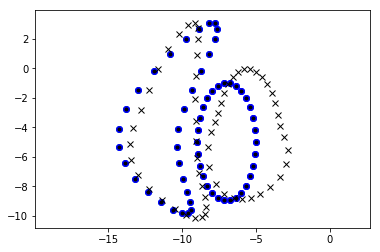

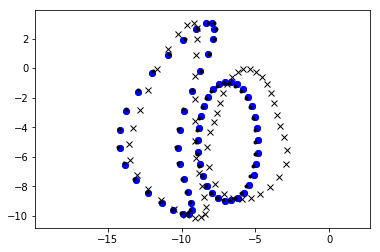

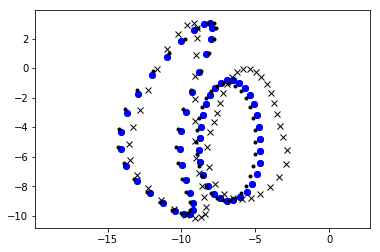

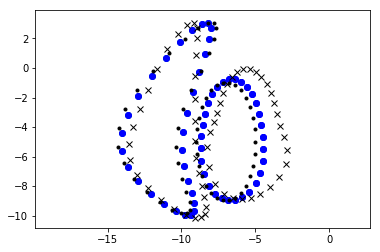

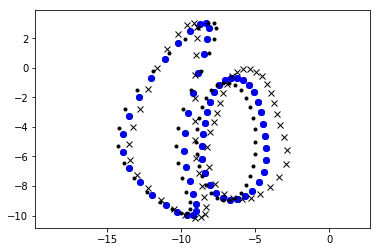

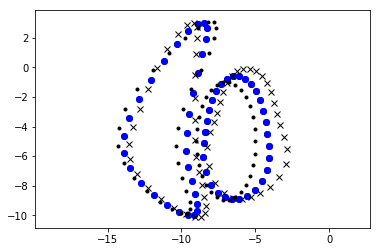

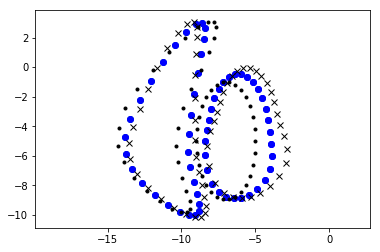

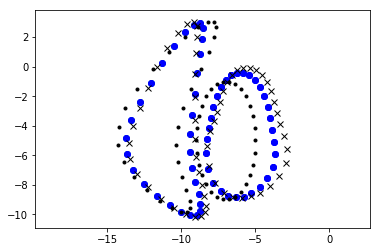

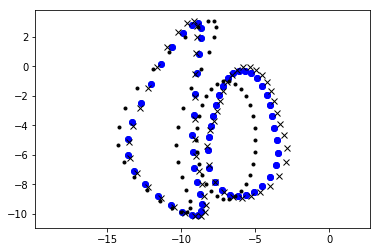

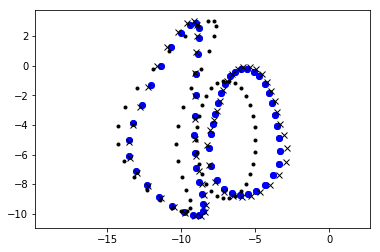

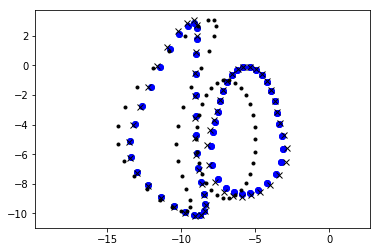

In [17]:
#%matplotlib qt5
H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])

H.geodesic_controls()

states, controls = dm.shooting.shoot_euler(H, it=10)

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

fig_shooting = plt.figure(figsize = (10,10), dpi=100)
for s,c in zip(states, colors):
    plt.figure()
    c= 'b'
    plt.scatter(s[0][0].gd.view(-1,2)[:, 0].detach().numpy(), s[0][0].gd.view(-1,2)[:, 1].detach().numpy())
    plt.scatter(s[1][0].gd.view(-1,2)[:, 0].detach().numpy(), s[1][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[2][0].gd.view(-1,2)[:, 0].detach().numpy(), s[2][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[2][1].gd.view(-1,2)[:, 0].detach().numpy(), s[2][1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
    plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

    plt.plot(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), '.k')
    plt.plot(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), '.k')

    
    plt.axis('equal')
    plt.show(fig_shooting)

In [35]:
# Visualization of grid deformation for each submodule
xmin = -15
xmax = 0
ymin = -10
ymax = 5
dx = 0.25
dy = 0.25
nx = int((xmax-xmin)/dx)
ny = int((ymax-ymin)/dy)
x,y,gridpoints = mm.gridpoints(xmin, xmax, ymin, ymax, dx, dy)

label = mm.point_labels(source, gridpoints).view(nx, ny)

H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])
grid_states, grid_controls, grid_intermediate = dm.shooting.shoot_euler_silent(H, gridpoints, it=10)

grid_final = grid_intermediate[-1]

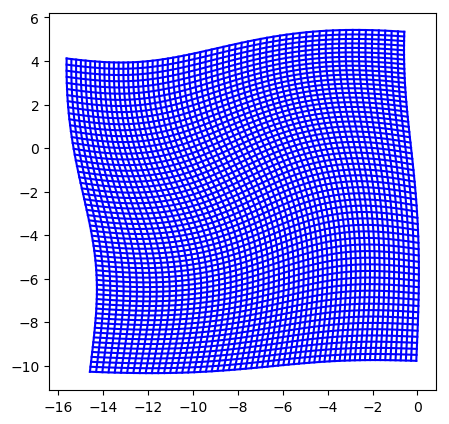

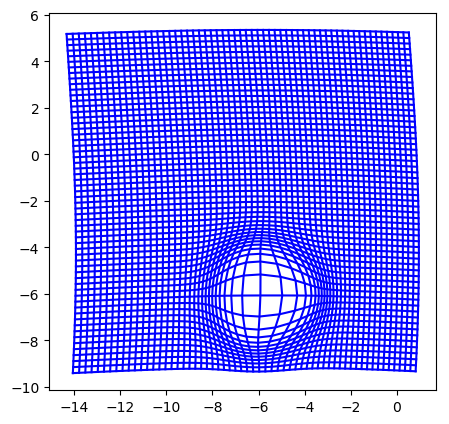

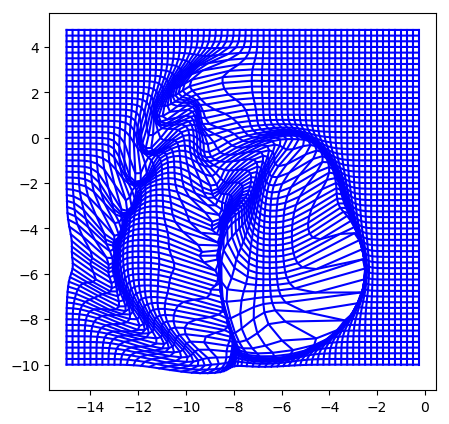

In [36]:
x1, y1 = dm.usefulfunctions.vec2grid(grid_final[0], nx,ny)
x2, y2 = dm.usefulfunctions.vec2grid(grid_final[1], nx,ny)
x3, y3 = dm.usefulfunctions.vec2grid(grid_final[2], nx,ny)


fig_grid1 = mm.plot_grid(x1.detach().numpy(), y1.detach().numpy(), color = 'blue', figsize=figsize, dpi=dpi)
fig_grid2 = mm.plot_grid(x2.detach().numpy(), y2.detach().numpy(), color = 'blue', figsize=figsize, dpi=dpi)
fig_grid_bg = mm.plot_grid( x3.detach().numpy(), y3.detach().numpy(), color = 'blue', figsize=figsize, dpi=dpi)
plt.show()

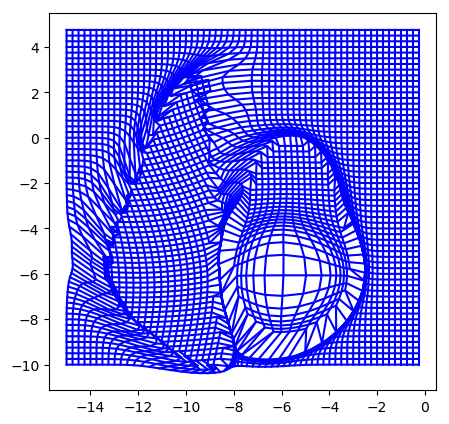

In [37]:
label = mm.point_labels(source, gridpoints).view(nx, ny)
phi_grid = []

plt.figure(figsize=(10,10), dpi=100)
mm.plot_MultiGrid([[x1,y1], [x2,y2], [x3,y3]], [x, y], label)
plt.show()

In [ ]:
fig_shooting.savefig('results/movingOrgans/shooting.png')
fig_source.savefig('results/movingOrgans/source.png')
fig_target.savefig('results/movingOrgans/target.png')

fig_grid1.savefig('results/movingOrgans/grid1.png')
fig_grid2.savefig('results/movingOrgans/grid2.png')
fig_grid_bg.savefig('results/movingOrgans/grid_bg.png')

In [29]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.geodesic_controls()
                
        return H()
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

gd = gd0_tensor
mom = 1000*torch.rand(mom0_tensor.shape)


test_gradcheck_Hamiltonian()

True